In [18]:
import os
import sys
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import roc_curve, auc, confusion_matrix


from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, precision_recall_curve, classification_report
import joblib

# Make sure "scripts" is in your Python path so you can import from scripts/preprocessing.py
sys.path.append('scripts')

# Import your functions and feature list
from preprocessing import preprocess, selected_features


In [21]:
def plot_roc(y_true, y_proba, title='ROC Curve'):
    fpr, tpr, _ = roc_curve(y_true, y_proba)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(5,4))
    plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
    plt.plot([0,1], [0,1],'k--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(title)
    plt.legend(loc="lower right")
    plt.show()

def plot_conf_matrix(y_true, y_pred, title='Confusion Matrix'):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(4,3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(title)
    plt.show()


In [4]:
# --- Data Preprocessing ---
DATA_PATH = "data/raw/HR_Attrition_Dataset.csv"

# CALL YOUR FUNCTION (assumes returns train/val/test splits in same order as before)
X_train, X_val, X_test, y_train, y_val, y_test = preprocess(data_path=DATA_PATH)


In [13]:
# Set up StratifiedKFold
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# Expanded hyperparameter grid with class_weight tuning
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l2'],
    'solver': ['lbfgs', 'liblinear'],
    'class_weight': [None, 'balanced', {0: 1, 1: 2}, {0: 1, 1: 3}, {0: 1, 1: 5}]
}

# Base classifier (no class_weight here, let grid search tune it)
clf = LogisticRegression(max_iter=1000, random_state=42)

# GridSearchCV with F1 scoring
grid_search = GridSearchCV(
    estimator=clf,
    param_grid=param_grid,
    scoring='f1',
    cv=skf,
    verbose=2,
    n_jobs=-1
)

# Fit model
grid_search.fit(X_train, y_train)
print("\nBest Parameters:", grid_search.best_params_)
print("Best F1 Score (CV):", grid_search.best_score_)

# Best estimator
best_logreg = grid_search.best_estimator_


Fitting 5 folds for each of 50 candidates, totalling 250 fits

Best Parameters: {'C': 0.1, 'class_weight': {0: 1, 1: 2}, 'penalty': 'l2', 'solver': 'lbfgs'}
Best F1 Score (CV): 0.5254285714285715


In [14]:
# --- Get Cross-Validation Results ---
cv_results = pd.DataFrame(grid_search.cv_results_)
leaderboard = cv_results.loc[:, ['params', 'mean_test_score', 'std_test_score']]
leaderboard = leaderboard.rename(columns={'mean_test_score': 'mean_F1', 'std_test_score': 'std_F1'})
leaderboard = leaderboard.sort_values(by="mean_F1", ascending=False)
print("\nTop 10 Hyperparameter Combinations:")
print(leaderboard.head(10))


Top 10 Hyperparameter Combinations:
                                               params   mean_F1    std_F1
14  {'C': 0.1, 'class_weight': {0: 1, 1: 2}, 'pena...  0.525429  0.043203
45  {'C': 100, 'class_weight': {0: 1, 1: 2}, 'pena...  0.520453  0.044337
34  {'C': 10, 'class_weight': {0: 1, 1: 2}, 'penal...  0.520453  0.044337
35  {'C': 10, 'class_weight': {0: 1, 1: 2}, 'penal...  0.520453  0.044337
44  {'C': 100, 'class_weight': {0: 1, 1: 2}, 'pena...  0.520453  0.044337
24  {'C': 1, 'class_weight': {0: 1, 1: 2}, 'penalt...  0.513588  0.044207
25  {'C': 1, 'class_weight': {0: 1, 1: 2}, 'penalt...  0.513588  0.044207
47  {'C': 100, 'class_weight': {0: 1, 1: 3}, 'pena...  0.511523  0.052599
46  {'C': 100, 'class_weight': {0: 1, 1: 3}, 'pena...  0.511523  0.052599
37  {'C': 10, 'class_weight': {0: 1, 1: 3}, 'penal...  0.511523  0.052599


In [ ]:
# --- THRESHOLD OPTIMIZATION (USING VALIDATION SET) ---
# Get predicted probabilities on validation set
y_proba_val = best_logreg.predict_proba(X_val)[:, 1]

# Calculate precision, recall at various thresholds
precision_vals, recall_vals, thresholds = precision_recall_curve(y_val, y_proba_val)

# Calculate F1 for each threshold
f1_scores = 2 * (precision_vals * recall_vals) / (precision_vals + recall_vals + 1e-8)

# Find best threshold (maximizes F1)
best_idx = np.argmax(f1_scores[:-1]) 
best_threshold = thresholds[best_idx]
best_f1_val = f1_scores[best_idx]

print(f"\n--- Threshold Optimization ---")
print(f"Best Threshold: {best_threshold:.4f}")
print(f"Best F1 Score (Validation): {best_f1_val:.4f}")
print(f"Precision at Best Threshold: {precision_vals[best_idx]:.4f}")
print(f"Recall at Best Threshold: {recall_vals[best_idx]:.4f}")



--- Threshold Optimization ---
Best Threshold: 0.4400
Best F1 Score (Validation): 0.6452
Precision at Best Threshold: 0.6522
Recall at Best Threshold: 0.6383


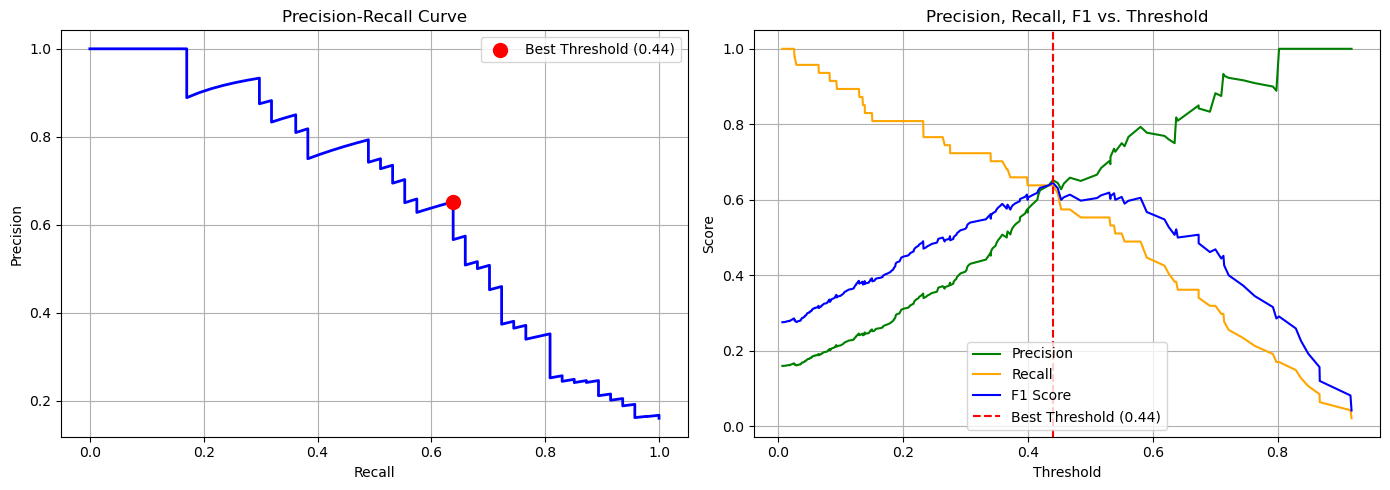

In [22]:
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Precision-Recall Curve
ax[0].plot(recall_vals, precision_vals, color='blue', lw=2)
ax[0].scatter(recall_vals[best_idx], precision_vals[best_idx], color='red', s=100, zorder=5, label=f'Best Threshold ({best_threshold:.2f})')
ax[0].set_xlabel('Recall')
ax[0].set_ylabel('Precision')
ax[0].set_title('Precision-Recall Curve')
ax[0].legend()
ax[0].grid(True)

# Plot 2: F1, Precision, Recall vs Threshold
ax[1].plot(thresholds, precision_vals[:-1], label='Precision', color='green')
ax[1].plot(thresholds, recall_vals[:-1], label='Recall', color='orange')
ax[1].plot(thresholds, f1_scores[:-1], label='F1 Score', color='blue')
ax[1].axvline(x=best_threshold, color='red', linestyle='--', label=f'Best Threshold ({best_threshold:.2f})')
ax[1].set_xlabel('Threshold')
ax[1].set_ylabel('Score')
ax[1].set_title('Precision, Recall, F1 vs. Threshold')
ax[1].legend()
ax[1].grid(True)

plt.tight_layout()
plt.show()


--- Validation Set Metrics (Default Threshold = 0.5) ---
Accuracy:  0.8844
Precision: 0.6667
Recall:    0.5532
F1 Score:  0.6047
ROC AUC:   0.8280


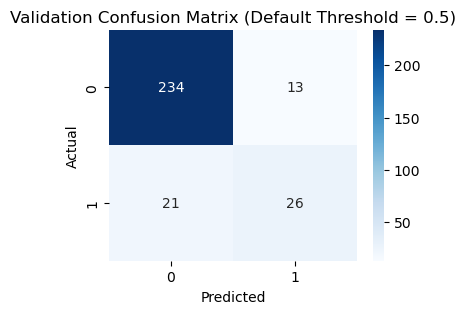


--- Validation Set Metrics (Optimized Threshold = 0.4400) ---
Accuracy:  0.8878
Precision: 0.6522
Recall:    0.6383
F1 Score:  0.6452
ROC AUC:   0.8280


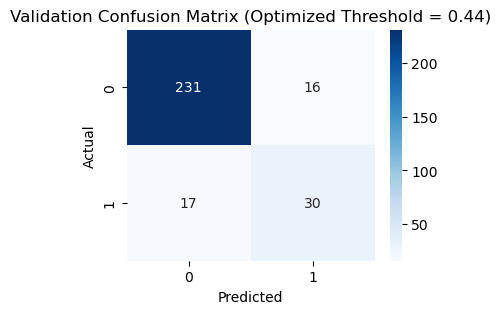

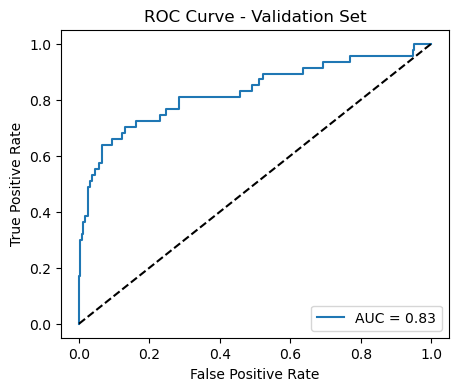

In [23]:
# Predictions using default and optimized threshold
y_pred_val_default = best_logreg.predict(X_val)
y_pred_val_optimized = (y_proba_val >= best_threshold).astype(int)

print("\n--- Validation Set Metrics (Default Threshold = 0.5) ---")
print(f"Accuracy:  {accuracy_score(y_val, y_pred_val_default):.4f}")
print(f"Precision: {precision_score(y_val, y_pred_val_default):.4f}")
print(f"Recall:    {recall_score(y_val, y_pred_val_default):.4f}")
print(f"F1 Score:  {f1_score(y_val, y_pred_val_default):.4f}")
print(f"ROC AUC:   {roc_auc_score(y_val, y_proba_val):.4f}")

# Confusion Matrix - Validation (Default)
plot_conf_matrix(y_val, y_pred_val_default, title='Validation Confusion Matrix (Default Threshold = 0.5)')

print(f"\n--- Validation Set Metrics (Optimized Threshold = {best_threshold:.4f}) ---")
print(f"Accuracy:  {accuracy_score(y_val, y_pred_val_optimized):.4f}")
print(f"Precision: {precision_score(y_val, y_pred_val_optimized):.4f}")
print(f"Recall:    {recall_score(y_val, y_pred_val_optimized):.4f}")
print(f"F1 Score:  {f1_score(y_val, y_pred_val_optimized):.4f}")
print(f"ROC AUC:   {roc_auc_score(y_val, y_proba_val):.4f}")

# Confusion Matrix - Validation (Optimized)
plot_conf_matrix(y_val, y_pred_val_optimized, title=f'Validation Confusion Matrix (Optimized Threshold = {best_threshold:.2f})')

# ROC Curve - Validation
plot_roc(y_val, y_proba_val, title='ROC Curve - Validation Set')


FINAL TEST SET EVALUATION

--- Test Set Metrics (Default Threshold = 0.5) ---
Accuracy:  0.8707
Precision: 0.6286
Recall:    0.4681
F1 Score:  0.5366
ROC AUC:   0.7970


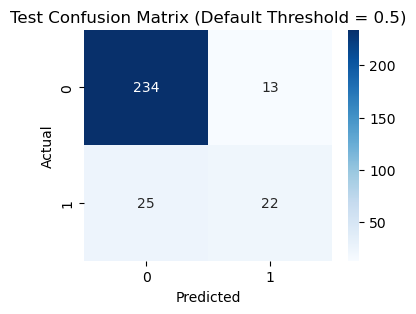


--- Test Set Metrics (Optimized Threshold = 0.4400) ---
Accuracy:  0.8333
Precision: 0.4808
Recall:    0.5319
F1 Score:  0.5051
ROC AUC:   0.7970


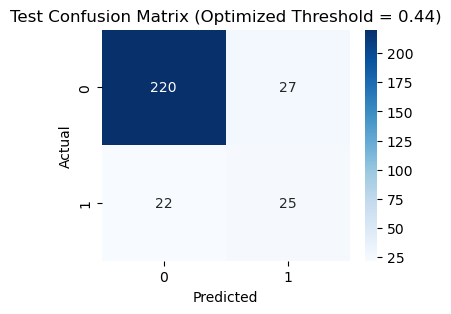

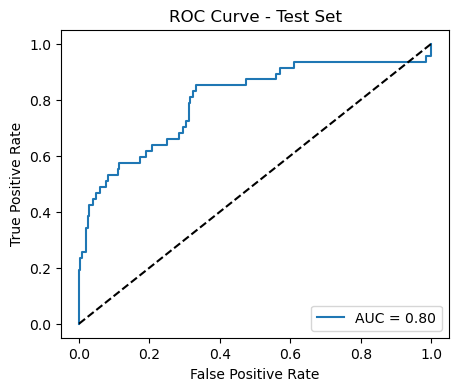


--- Classification Report (Optimized Threshold) ---
              precision    recall  f1-score   support

        Stay       0.91      0.89      0.90       247
       Leave       0.48      0.53      0.51        47

    accuracy                           0.83       294
   macro avg       0.69      0.71      0.70       294
weighted avg       0.84      0.83      0.84       294



In [24]:
# Get predicted probabilities on test set
y_proba_test = best_logreg.predict_proba(X_test)[:, 1]

# Predictions using default and optimized threshold
y_pred_test_default = best_logreg.predict(X_test)
y_pred_test_optimized = (y_proba_test >= best_threshold).astype(int)

print("\n" + "="*60)
print("FINAL TEST SET EVALUATION")
print("="*60)

print("\n--- Test Set Metrics (Default Threshold = 0.5) ---")
print(f"Accuracy:  {accuracy_score(y_test, y_pred_test_default):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_test_default):.4f}")
print(f"Recall:    {recall_score(y_test, y_pred_test_default):.4f}")
print(f"F1 Score:  {f1_score(y_test, y_pred_test_default):.4f}")
print(f"ROC AUC:   {roc_auc_score(y_test, y_proba_test):.4f}")

# Confusion Matrix - Test (Default)
plot_conf_matrix(y_test, y_pred_test_default, title='Test Confusion Matrix (Default Threshold = 0.5)')

print(f"\n--- Test Set Metrics (Optimized Threshold = {best_threshold:.4f}) ---")
print(f"Accuracy:  {accuracy_score(y_test, y_pred_test_optimized):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_test_optimized):.4f}")
print(f"Recall:    {recall_score(y_test, y_pred_test_optimized):.4f}")
print(f"F1 Score:  {f1_score(y_test, y_pred_test_optimized):.4f}")
print(f"ROC AUC:   {roc_auc_score(y_test, y_proba_test):.4f}")

# Confusion Matrix - Test (Optimized)
plot_conf_matrix(y_test, y_pred_test_optimized, title=f'Test Confusion Matrix (Optimized Threshold = {best_threshold:.2f})')

# ROC Curve - Test
plot_roc(y_test, y_proba_test, title='ROC Curve - Test Set')

# Classification report
print("\n--- Classification Report (Optimized Threshold) ---")
print(classification_report(y_test, y_pred_test_optimized, target_names=['Stay', 'Leave']))


--- Top 10 Most Important Features ---
                              feature  coefficient  abs_coefficient
9                TotalWorkingYearsLog    -0.843522         0.843522
11                       OverTime_Yes     0.809104         0.809104
5    BusinessTravel_Travel_Frequently     0.682357         0.682357
7   Department_Research & Development    -0.585745         0.585745
12      JobRole_Laboratory Technician     0.573108         0.573108
10               MaritalStatus_Single     0.560755         0.560755
18                Job_happiness_score    -0.398665         0.398665
16                 NumCompaniesWorked     0.390516         0.390516
3           JobRole_Research Director    -0.318784         0.318784
4        JobRole_Sales Representative     0.292629         0.292629


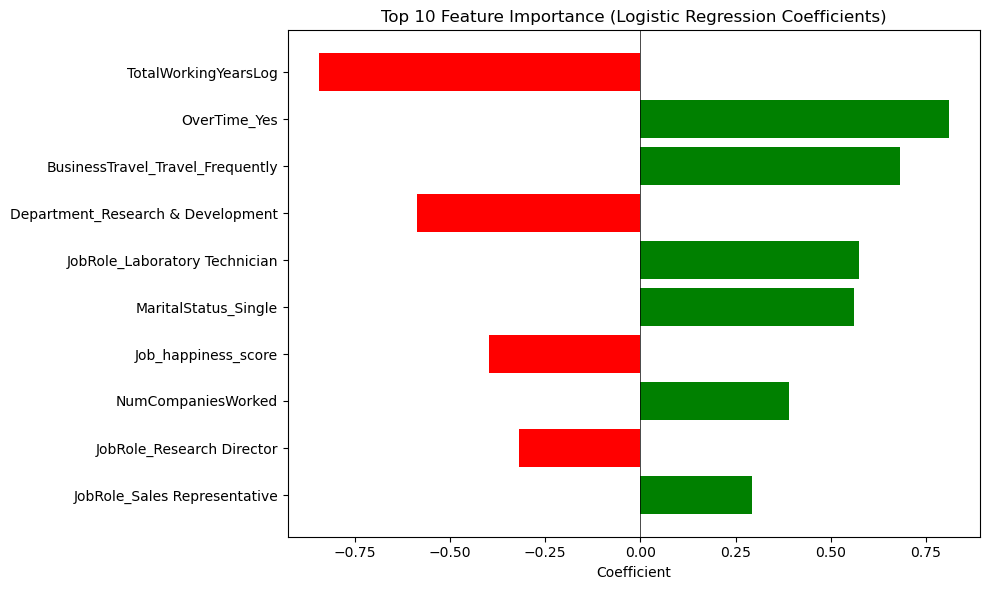

In [26]:
# Get feature importance from coefficients
feature_names = X_train.columns
coefficients = best_logreg.coef_[0]
feature_importance = pd.DataFrame({
    'feature': feature_names,
    'coefficient': coefficients,
    'abs_coefficient': np.abs(coefficients)
}).sort_values('abs_coefficient', ascending=False)

print("\n--- Top 10 Most Important Features ---")
print(feature_importance.head(10))

# Plot feature importance
plt.figure(figsize=(10, 6))
top_features = feature_importance.head(10)
colors = ['green' if c > 0 else 'red' for c in top_features['coefficient']]
plt.barh(top_features['feature'][::-1], top_features['coefficient'][::-1], color=colors[::-1])
plt.xlabel('Coefficient')
plt.title('Top 10 Feature Importance (Logistic Regression Coefficients)')
plt.axvline(x=0, color='black', linestyle='-', linewidth=0.5)
plt.tight_layout()
plt.show()

In [ ]:
MODEL_PATH = 'models'
os.makedirs(MODEL_PATH, exist_ok=True)
model_filename = os.path.join(MODEL_PATH, 'logistic_regression_best.pkl')
joblib.dump(best_logreg, model_filename)
print(f"Model saved to {model_filename}")


In [ ]:
# Validation run logging
log_file_val = "logs/logreg_runs.json"
log_experiment(
    log_file=log_file_val,
    model_name="Logistic Regression (Validation)",
    variables=selected_features,
    params=grid_search.best_params_,
    metrics=val_metrics
)
print(f"Validation run logged to {log_file_val}")

# Test run logging
log_file_test = "logs/logreg_test_runs.json"
log_experiment(
    log_file=log_file_test,
    model_name="Logistic Regression (Test)",
    variables=selected_features,
    params=grid_search.best_params_,
    metrics=test_metrics
)
print(f"Test run logged to {log_file_test}")
